## Create non IID dataset with different frequencies

Test script, to be integrated in main pipeline

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from lib.generate_timeseries import Periodic_1d
import torch
from collections import Counter
from matplotlib import cm
from torch.distributions import uniform
import pandas as pd
import seaborn as sns
import sys
from flower.task import Net
import json
import glob
import os
os.chdir("/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/bin")
sys.path.append(os.getcwd()) 
# Ensure seaborn theme
sns.set(style='whitegrid')
from lib.dataset_utils import *
from plot_utils import plot_n_outputs

%matplotlib inline
%load_ext autoreload
%autoreload 2
path_prefix = "/Users/luisa/Desktop/nygc/cluster/projects/fl4tsf/data"

from plot_utils import read_loss_file

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Plot the results

In [120]:
result_json = glob.glob(f"../results_freq_noise/*maxfreq*/federated_training/**/100_rounds/**/results.json", recursive=True)
len(result_json)

188

In [139]:
convergence_range = 1.1

start_freq = 0.1
df_summary_centralized = pd.DataFrame()
df_summary_federated = pd.DataFrame()
df_summary_aggregation = pd.DataFrame()
for file in result_json:
    # max frequency is encoded in the filename
    max_freq = float(file.split("maxfreq_")[-1].split("_")[0].split("/")[0])
    difference = max_freq - start_freq
    df_centralized_evaluate, df_federated_evaluate, df_aggregation = read_loss_file(file)
    df_centralized_evaluate['max_freq'] = max_freq
    df_centralized_evaluate['difference'] = difference
    df_summary_centralized = pd.concat([df_summary_centralized, df_centralized_evaluate], ignore_index=True)
    df_federated_evaluate['max_freq'] = max_freq
    df_federated_evaluate['difference'] = difference
    df_summary_federated = pd.concat([df_summary_federated, df_federated_evaluate], ignore_index=True)
    df_aggregation['max_freq'] = max_freq
    df_aggregation['difference'] = difference
    df_summary_aggregation = pd.concat([df_summary_aggregation, df_aggregation], ignore_index=True)

# find the min loss for each difference, aggreagation, type 
df_summary_centralized['min_loss'] = df_summary_centralized.groupby(['difference', 'aggregation', 'type'])['loss'].transform('min')

# per difference, aggregation, type get the convergence_round, which is the min round where the loss is within 1/10 of the min loss
df_summary_centralized['convergence_round'] = df_summary_centralized.groupby(['difference', 'aggregation', 'type'])['round'].transform(
    lambda x: x[df_summary_centralized['loss'] <= df_summary_centralized['min_loss'] * convergence_range].min()
)

df_summary_federated['min_loss'] = df_summary_federated.groupby(['difference', 'aggregation', 'type'])['loss'].transform('min')
df_summary_federated['convergence_round'] = df_summary_federated.groupby(['difference', 'aggregation', 'type'])['round'].transform(
    lambda x: x[df_summary_federated['loss'] <= df_summary_federated['min_loss'] * convergence_range].min()
)



In [140]:
df_summary_federated = df_summary_federated[['round', 'loss', 'aggregation', 'type', 'alpha', 'difference', 'min_loss', 'convergence_round']]
df_summary_centralized = df_summary_centralized[['round', 'loss', 'aggregation', 'type', 'alpha', 'difference', 'min_loss', 'convergence_round']]
df_summary = pd.concat([df_summary_federated, df_summary_centralized], ignore_index=True)
df_summary

,round,loss,aggregation,type,alpha,difference,min_loss,convergence_round
0,1,1999.521393,FedODE,federated,1.00,0.15,1686.177734,70
1,2,4165.662476,FedODE,federated,1.00,0.15,1686.177734,70
2,3,2980.710876,FedODE,federated,1.00,0.15,1686.177734,70
3,4,2585.156494,FedODE,federated,1.00,0.15,1686.177734,70
4,5,2611.530579,FedODE,federated,1.00,0.15,1686.177734,70
...,...,...,...,...,...,...,...,...
37783,96,2273.701874,FedAvg,centralized,0.75,0.25,144.654157,93
37784,97,2438.391357,FedAvg,centralized,0.75,0.25,144.654157,93
37785,98,2188.562805,FedAvg,centralized,0.75,0.25,144.654157,93
37786,99,2547.506958,FedAvg,centralized,0.75,0.25,144.654157,93


<Figure size 1000x300 with 0 Axes>

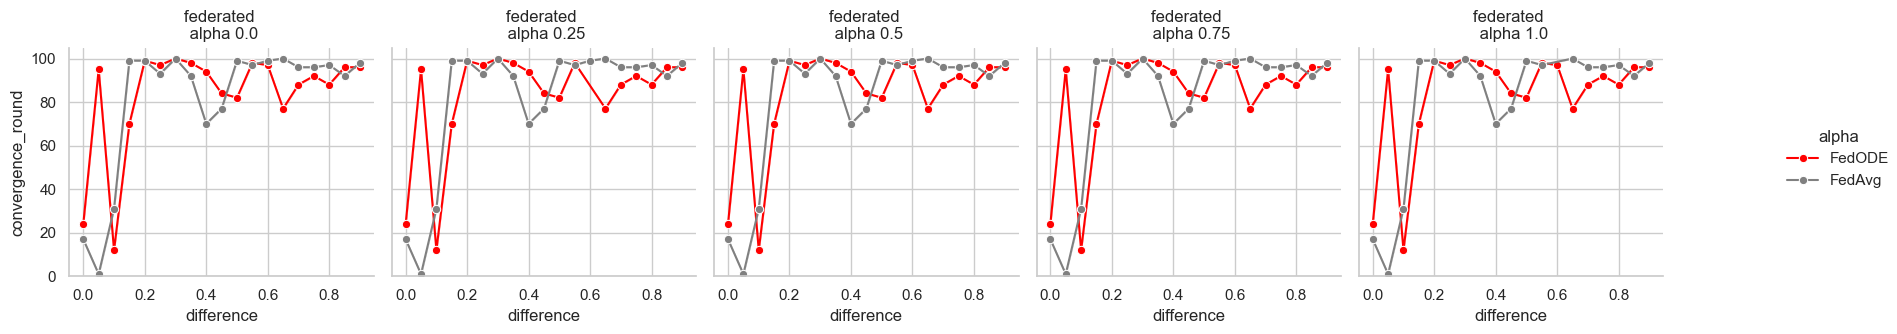

In [142]:
######################################
#  Plot the last loss vs difference
#######################################
plt.figure(figsize=(10, 3))
# Create FacetGrid
g = sns.FacetGrid(
    df_summary_federated,
    col="alpha",
    row = "type",
    height=3.5,
    aspect=0.9,  # Width = height * aspect
    sharey=True
)
# make palette red and grey 
palette_red_grey = {
    'FedODE': 'red',
    'FedAvg': 'grey'
}

# Map the lineplot onto the grid
g.map_dataframe(
    sns.lineplot,
    x='difference',
    y='convergence_round',
    hue='aggregation',
    palette=palette_red_grey,
    marker ='o'
)

# Adjustments
g.set_titles("{row_name} \n alpha {col_name}")
g.set(ylim=(0, None))



# Move legend outside
g.add_legend(title ="alpha")
g._legend.set_bbox_to_anchor((1.05, 0.5))
# legend 
g._legend.set_loc("center left")
# title
plt.tight_layout()
plt.show()


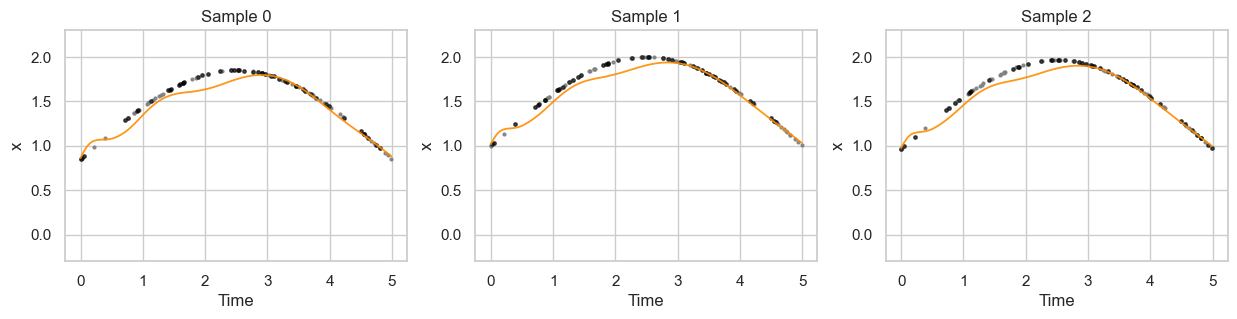

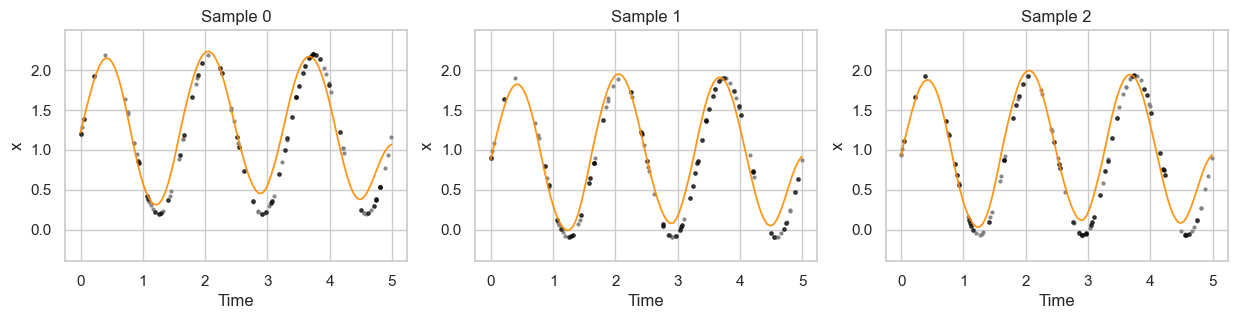

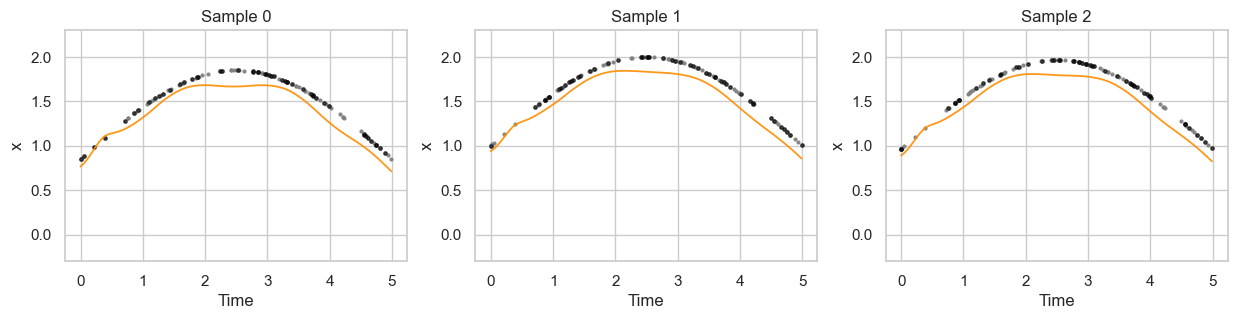

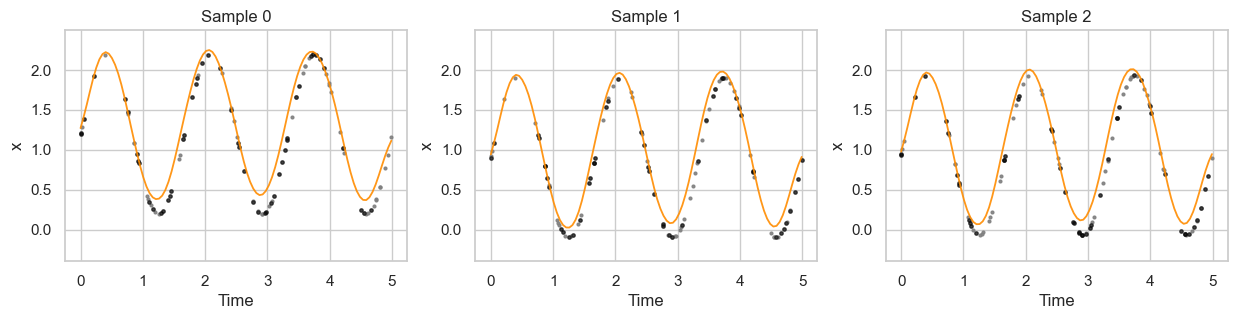

In [130]:
max_freq = 0.6
alpha = 0.0
data_folder = "../data/"
dataset_prefix = f"freq_steps_maxfreq_{max_freq}"

data_files_0 = glob.glob(os.path.join(data_folder, f"{dataset_prefix}/client_0_test.pt"))[0]
data_files_1 = glob.glob(os.path.join(data_folder, f"{dataset_prefix}/client_1_test.pt"))[0]
timestamps_0 = glob.glob(os.path.join(data_folder, f"{dataset_prefix}/client_0_time_steps_test.pt"))[0]
timestamps_1 = glob.glob(os.path.join(data_folder, f"{dataset_prefix}/client_1_time_steps_test.pt"))[0]
d_0 = torch.load(data_files_0, weights_only=True)
d_1 = torch.load(data_files_1, weights_only=True)
t_0 = torch.load(timestamps_0, weights_only=True)
t_1 = torch.load(timestamps_1, weights_only=True)
w_avg = glob.glob(os.path.join(path_prefix, f"../results_freq_noise/{dataset_prefix}/**/FedAvg/**/model.pth"), recursive=True)[0]
w_ode = glob.glob(os.path.join(path_prefix, f"../results_freq_noise/{dataset_prefix}/**/FedODE/**/model.pth"), recursive=True)[1]

model = Net()
model.load_state_dict(torch.load(w_avg, weights_only=True))
plot_n_outputs(model, d_0, t_0[0], n = 3 )
plot_n_outputs(model, d_1, t_1[0], n = 3 )


model.load_state_dict(torch.load(w_ode, weights_only=True))
plot_n_outputs(model, d_0, t_0[0], n = 3 )
plot_n_outputs(model, d_1, t_1[0], n = 3 )


In [144]:
df_summary_federated

,round,loss,aggregation,type,alpha,difference,min_loss,convergence_round
0,1,1999.521393,FedODE,federated,1.00,0.15,1686.177734,70
1,2,4165.662476,FedODE,federated,1.00,0.15,1686.177734,70
2,3,2980.710876,FedODE,federated,1.00,0.15,1686.177734,70
3,4,2585.156494,FedODE,federated,1.00,0.15,1686.177734,70
4,5,2611.530579,FedODE,federated,1.00,0.15,1686.177734,70
...,...,...,...,...,...,...,...,...
18795,96,2164.613953,FedAvg,federated,0.75,0.25,127.575119,93
18796,97,2362.196289,FedAvg,federated,0.75,0.25,127.575119,93
18797,98,2075.461304,FedAvg,federated,0.75,0.25,127.575119,93
18798,99,2499.588318,FedAvg,federated,0.75,0.25,127.575119,93


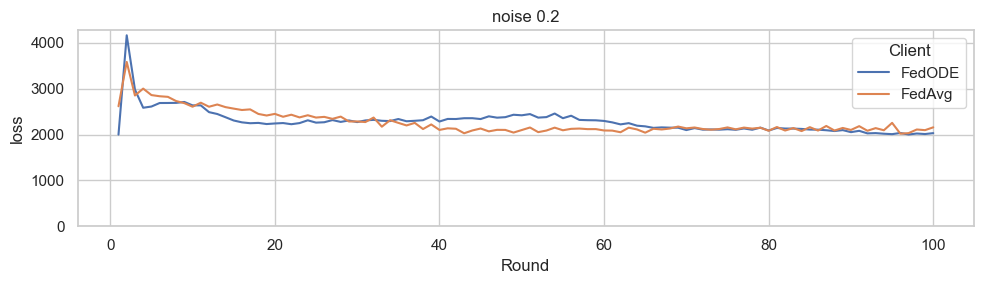

In [154]:
diff = 0.15
alpha = 1.0
df_test = df_summary_federated[(df_summary_federated['difference'] == diff) & (df_summary_federated['alpha'] == alpha)]
plt.figure(figsize=(10, 3))
sns.lineplot(data=df_test, x='round', y='loss', hue='aggregation', markers=True, dashes=False)
plt.title(f"noise {freq}")
plt.xlabel("Round")
plt.legend(title='Client')
# yaxis from 0
plt.ylim(0, None)
plt.tight_layout()
plt.show()

In [131]:
######################################
#  Plot the lambdas vs difference
#######################################

# fed ode results, keep files that contain "FedODE" in the path name
results_fed_ode = [file for file in result_json if "FedODE" in file]

df_summary = pd.DataFrame()
for file in results_fed_ode:
    #print(f"Processing file {file}...")
    # maxfreq find anything with maxfreq_ in the filename and extract what is after the _
    max_freq = float(file.split("maxfreq_")[-1].split("_")[0].split("/")[0])
    #print(f"Max frequency: {max_freq}")
    difference = max_freq - start_freq
    df_centralized_evaluate_temp, df_federated_evaluate_temp, df_aggregation_temp = read_loss_file(file)
    # merge by round
    df_summary_temp = pd.concat([df_centralized_evaluate_temp, df_federated_evaluate_temp])
    # merge df aggregation by round
    df_aggregation_temp['round'] = df_aggregation_temp['round'].astype(int)
    df_summary_temp = df_summary_temp.merge(df_aggregation_temp, on=['round', 'alpha'], how='left')
    df_summary_temp['max_freq'] = max_freq
    df_summary_temp['difference'] = difference
    df_summary = pd.concat([df_summary, df_summary_temp])

    # add df_aggregation to df_summary
# remove round 0 

# from df summary print x the rounds and y the lambdas 
df_summary['round'] = df_summary['round'].astype(int)
df_summary = df_summary[df_summary['round'] > 0]  # filter out round 0
# explode lambdas 
# lambdas contains a vector 
# take out the 2 lambdas and put them in a new column called lambda and a new column called client and containig 0 or 1\
df_summary['lambda_0'] = df_summary['lambdas'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else np.nan)
df_summary['lambda_1'] = df_summary['lambdas'].apply(lambda x: x[1] if isinstance(x, list) and len(x) > 1 else np.nan)
df0 = df_summary[['round', 'difference', 'lambda_0', 'aggregation', 'alpha']].copy()
df0['client'] = 0
df0 = df0.rename(columns={'lambda_0': 'lambda'})
df1 = df_summary[['round', 'difference', 'lambda_1', 'aggregation', 'alpha']].copy()
df1.rename(columns={'lambda_1': 'lambda'}, inplace=True)
df1['client'] = 1
df_summary_lambdas = pd.concat([df0, df1], ignore_index=True)
df_summary_lambdas_last = df_summary_lambdas[df_summary_lambdas["round"] == max(df_summary_lambdas["round"])]


<Figure size 1000x300 with 0 Axes>

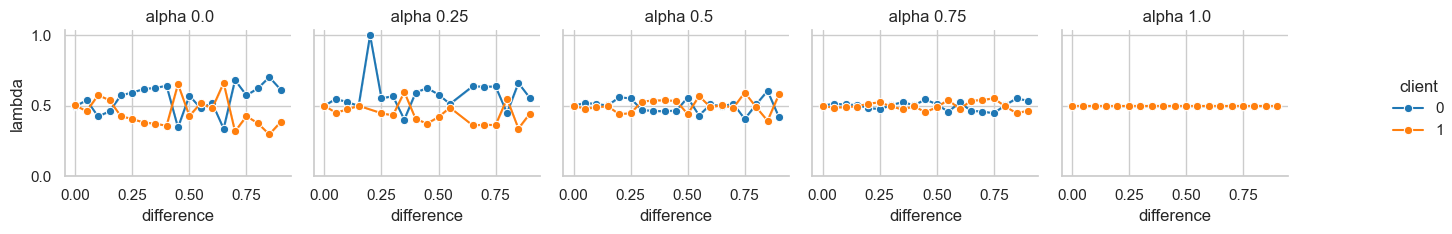

In [133]:

# ensure round is int
# plot
plt.figure(figsize=(10, 3))
# Create FacetGrid
g = sns.FacetGrid(
    df_summary_lambdas_last,
    col="alpha",
    row = "round",
    height=2.5,
    aspect=1.0,  # Width = height * aspect
    sharey=True,
)

# Map the lineplot onto the grid
g.map_dataframe(
    sns.lineplot,
    x='difference',
    y='lambda',
    hue="client",
    palette='tab10',
    marker='o'
)

# Adjustments
g.set_titles(" alpha {col_name}")
g.set(ylim=(0, None))

# Move legend outside
g.add_legend(title ="client")
g._legend.set_bbox_to_anchor((1.05, 0.5))
# legend 
g._legend.set_loc("center left")
# title
plt.tight_layout()
plt.show()